# DAG Discovery and Refutation

Link to the article:  [DAG Discovery and Refutation](https://www.linkedin.com/pulse/causal-inference-decision-intelligence-part-7-dag-eugene-zinoviev-bnfqc)

## Load the data and draw the true DAG 

In [1]:
import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict
import warnings

import numpy as np
import pandas as pd
import networkx as nx

from scipy import linalg 

from sklearn.linear_model import LinearRegression

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation 

from castle.algorithms import PC, GES
from castle.algorithms import ANMNonlinear, ICALiNGAM, DirectLiNGAM
from castle.algorithms import Notears, NotearsNonlinear, GOLEM

from castle.common.priori_knowledge import PrioriKnowledge

from castle.common.independence_tests import hsic_test

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

2025-08-30 13:46:08,442 - C:\Users\yevge\anaconda3\Lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [2]:
# Set up the colors
COLORS = ['#00B0F0', '#FF0000', '#B0F000']

In [3]:
# Create the dataset
np.random.seed(22)
Confounder = np.random.randn(1000)
Discount = np.random.choice([5, 10, 15, 20], size=1000, p=[0.3, 0.3, 0.25, 0.15]) - 5 * Confounder
Mediator = 4 * Discount + np.random.randn(1000) 
Sales = 3 * Discount + 5 * Confounder + 2 * Mediator + np.random.randn(1000)
df1 = pd.DataFrame({'Confounder': Confounder, 'Discount': Discount, 'Sales': Sales, 'Mediator': Mediator})

In [4]:
# Create the true DAG
G = nx.DiGraph([('Confounder', 'Discount'), ('Confounder', 'Sales'), ('Discount', 'Sales'), ('Discount', 'Mediator'), ('Mediator', 'Sales')])

# Create the list of labels for the DAG
labels = {0: 'Confounder', 1: 'Discount', 2: 'Sales', 3: 'Mediator'}

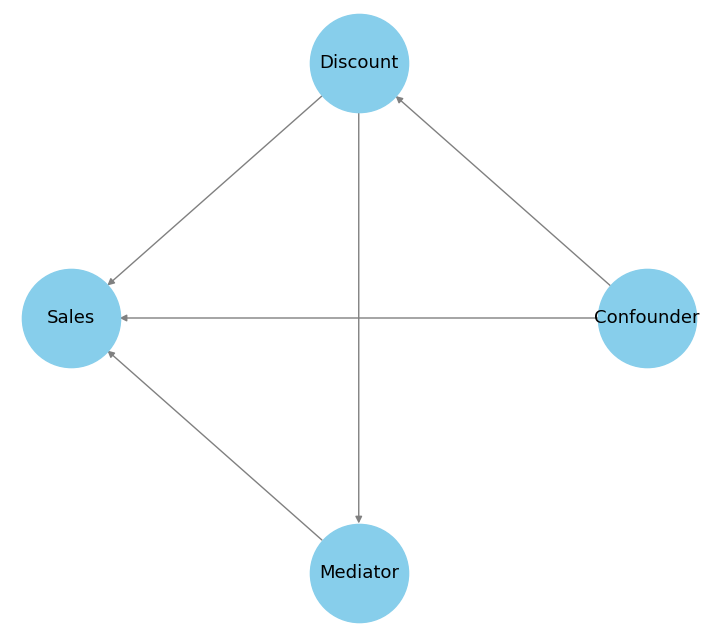

In [5]:
# Draw the true DAG
plt.figure(figsize=(9, 8))
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=5000, font_size=13, font_color='black', edge_color='gray', pos=nx.circular_layout(G))
# Remove the border
plt.gca().set_frame_on(False)

# Show the plot
plt.savefig('discovery.png')
plt.show();

## Discover the DAG from the data

### Constraint-based causal discovery

In [6]:
from castle.algorithms import PC

In [7]:
# Run PC algorithm
pc = PC()
pc.learn(df1)

In [8]:
# Build the causal matrix
pred_dag = pc.causal_matrix
pred_dag

Tensor([[0, 0, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 0],
        [1, 1, 1, 0]])

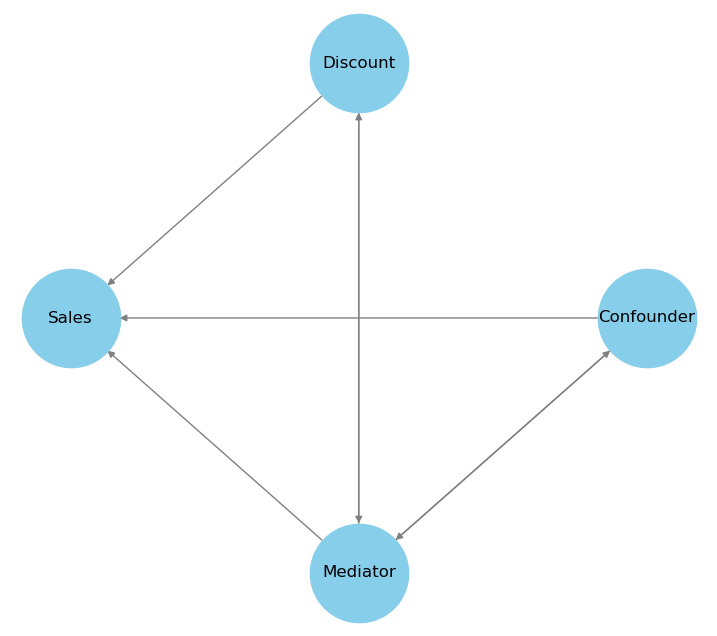

In [9]:
# Draw the discovered DAG

g_pred = nx.DiGraph(pred_dag)
pos = nx.circular_layout(g_pred)
plt.figure(figsize=(9, 8))
nx.draw_networkx(G=g_pred, with_labels=False, node_color='skyblue', node_size=5000, font_size=14, font_color='black', edge_color='gray', pos=pos)

nx.draw_networkx_labels(G, pos, labels, font_size=12)

# Remove the border
plt.gca().set_frame_on(False)

# Show the plot
plt.show();

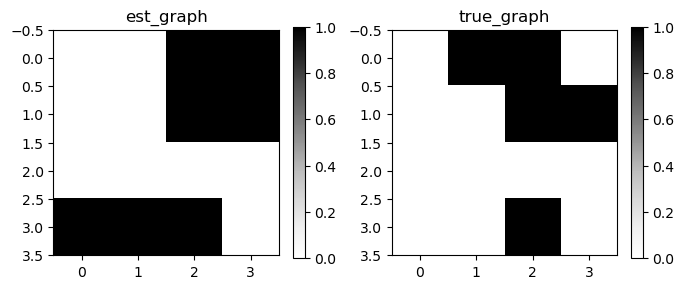

In [10]:
# Get the adjacency matrix of the true DAG
true = nx.adjacency_matrix(G)

# Convert to a NumPy array for easier manipulation
true = true.toarray()

GraphDAG(
    est_dag=pred_dag, 
    true_dag=true)

plt.show()

### Score-based causal discovery

In [11]:
# Instantiate GES
ges = GES(criterion='bic')

In [12]:
# Train GES
ges.learn(df1)

In [13]:
# Build the causal matrix
pred_ges = ges.causal_matrix
pred_ges

Tensor([[0, 0, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 0],
        [1, 1, 1, 0]])

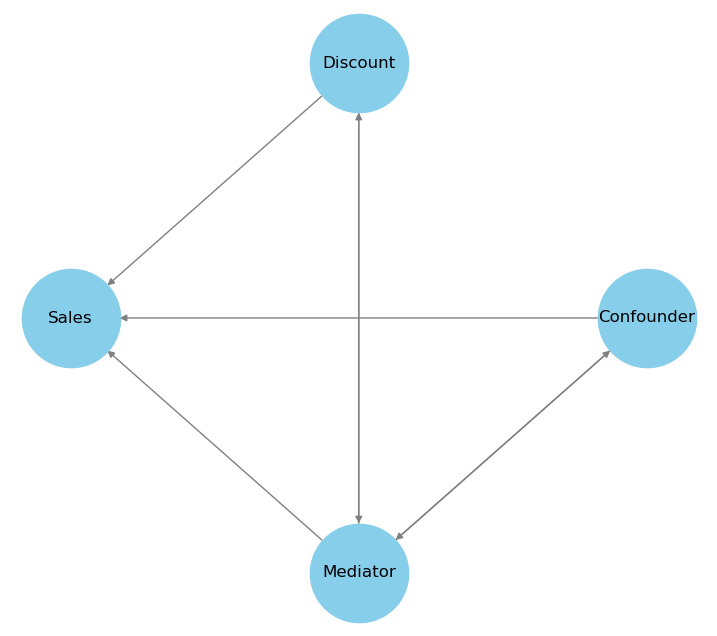

In [14]:
# Draw the discovered DAG 
ges_pred = nx.DiGraph(pred_ges)
pos = nx.circular_layout(ges_pred)
plt.figure(figsize=(9, 8))
nx.draw_networkx(G=ges_pred, with_labels=False, node_color='skyblue', node_size=5000, font_size=14, font_color='black', edge_color='gray', pos=pos)

nx.draw_networkx_labels(G, pos, labels, font_size=12)

# Remove the border
plt.gca().set_frame_on(False)

# Show the plot
plt.show();

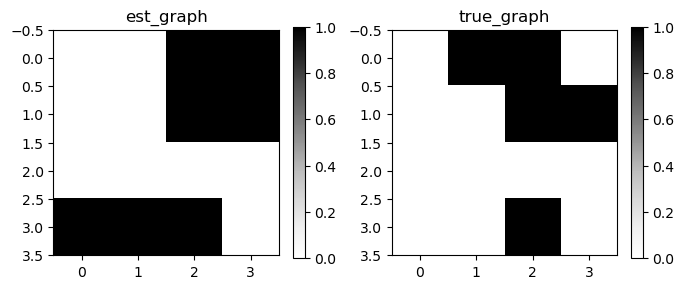

In [15]:
# Get the adjacency matrix of the true DAG
true = nx.adjacency_matrix(G)

# Convert to a NumPy array for easier manipulation
true = true.toarray()

GraphDAG(
    est_dag=pred_ges, 
    true_dag=true)

plt.show()

### LiNGAM algorithm

In [16]:
# Set random seed
SEED = 18
np.random.seed(SEED)

# Instantiate the model
lingam = ICALiNGAM(random_state=SEED)

# Fit
lingam.learn(df1)

In [17]:
# Build the causal matrix
pred_lingam = lingam.causal_matrix
pred_lingam

Tensor([[0, 1, 1, 0],
        [0, 0, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 1, 0]])

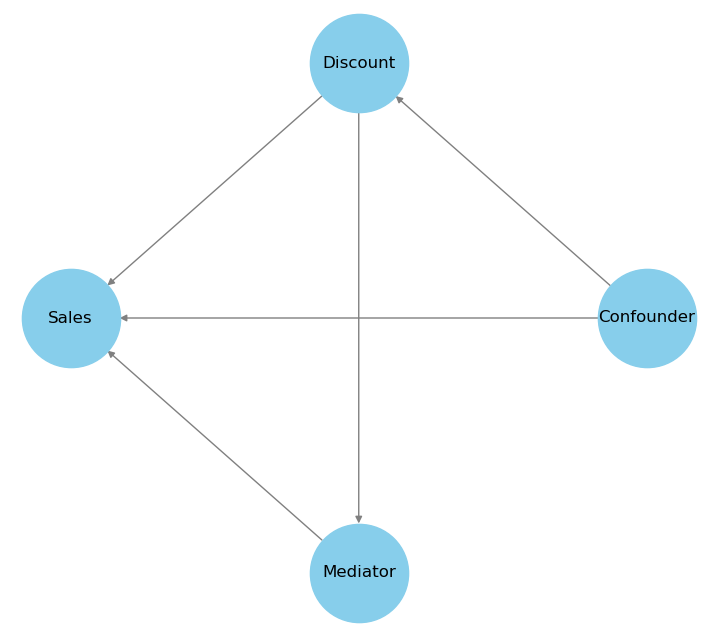

In [18]:
# Draw the discovered DAG 
lingam_pred = nx.DiGraph(pred_lingam)
pos = nx.circular_layout(lingam_pred)
plt.figure(figsize=(9, 8))
nx.draw_networkx(G=lingam_pred, with_labels=False, node_color='skyblue', node_size=5000, font_size=14, font_color='black', edge_color='gray', pos=pos)

nx.draw_networkx_labels(G, pos, labels, font_size=12)

# Remove the border
plt.gca().set_frame_on(False)

# Show the plot
plt.show();

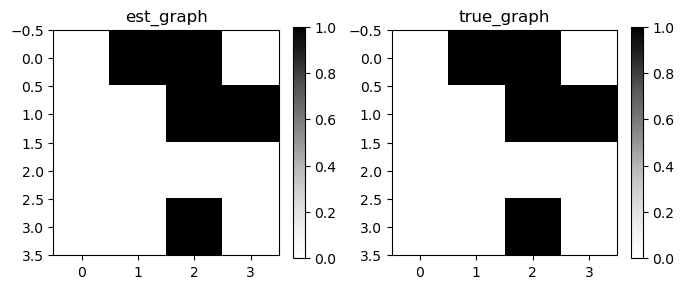

In [19]:
plt.style.use('default')

GraphDAG(
    est_dag=lingam.causal_matrix, 
    true_dag=true)

plt.show()

### Compare different algorithms

In [21]:
# Pick the methods
methods = OrderedDict({
    'PC': PC,
    'GES': GES,
    'LiNGAM': DirectLiNGAM,
    'Notears': NotearsNonlinear,
    'GOLEM': GOLEM
})

Method: PC


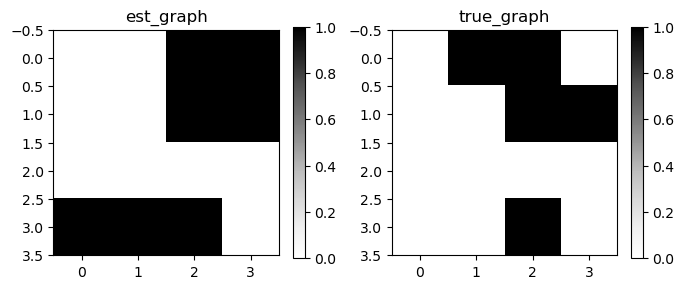

FDR: 0.2
Recall: 0.8
Precision: 0.5714
F1 score: 0.6667
SHD score: 2
-------------------------------------------------- 

Method: GES


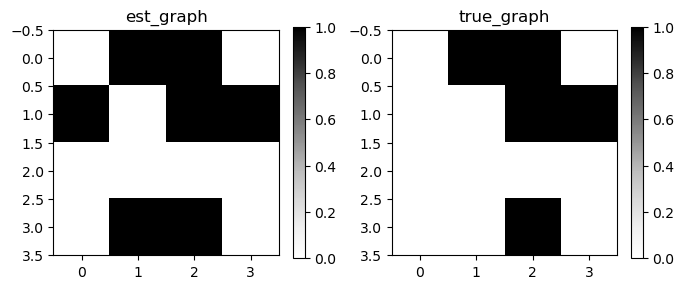

FDR: 0.0
Recall: 1.0
Precision: 0.7143
F1 score: 0.8333
SHD score: 0
-------------------------------------------------- 

Method: LiNGAM


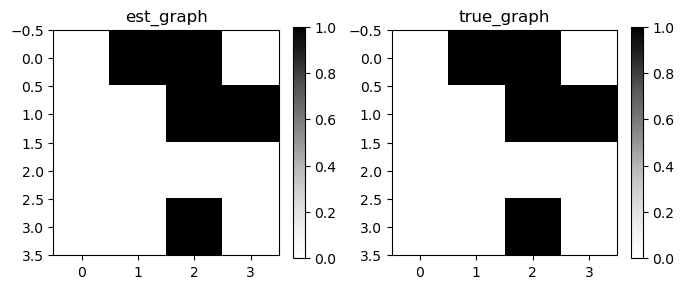

2025-02-05 20:03:13,373 - C:\Users\yevge\anaconda3\Lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:137] - INFO: GPU is unavailable.
2025-02-05 20:03:13,377 - C:\Users\yevge\anaconda3\Lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:237] - INFO: [start]: n=1000, d=4, iter_=100, h_=1e-08, rho_=1e+16


FDR: 0.0
Recall: 1.0
Precision: 1.0
F1 score: 1.0
SHD score: 0
-------------------------------------------------- 

Method: Notears


2025-02-05 20:09:12,435 - C:\Users\yevge\anaconda3\Lib\site-packages\castle\algorithms\gradient\notears\torch\nonlinear.py[line:249] - INFO: FINISHED


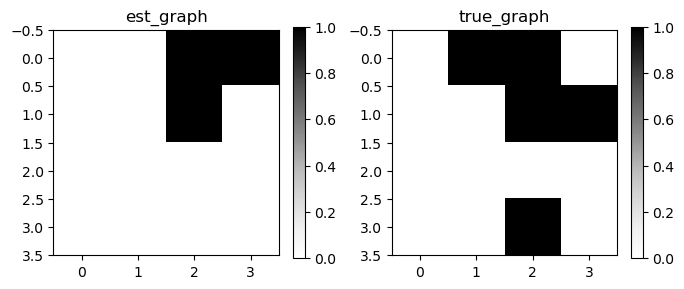

2025-02-05 20:09:12,776 - C:\Users\yevge\anaconda3\Lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:122] - INFO: GPU is unavailable.
2025-02-05 20:09:12,798 - C:\Users\yevge\anaconda3\Lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:207] - INFO: Started training for 25000 iterations.
2025-02-05 20:09:12,805 - C:\Users\yevge\anaconda3\Lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 0] score=33.647, likelihood=33.647, h=0.0e+00


FDR: 0.3333
Recall: 0.4
Precision: 0.6667
F1 score: 0.5
SHD score: 4
-------------------------------------------------- 

Method: GOLEM


2025-02-05 20:09:21,570 - C:\Users\yevge\anaconda3\Lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 5000] score=20.294, likelihood=19.184, h=1.7e-01
2025-02-05 20:09:30,346 - C:\Users\yevge\anaconda3\Lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 10000] score=20.259, likelihood=19.149, h=1.7e-01
2025-02-05 20:09:39,272 - C:\Users\yevge\anaconda3\Lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 15000] score=20.259, likelihood=19.149, h=1.7e-01
2025-02-05 20:09:48,031 - C:\Users\yevge\anaconda3\Lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 20000] score=20.259, likelihood=19.148, h=1.7e-01
2025-02-05 20:09:58,214 - C:\Users\yevge\anaconda3\Lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 25000] score=20.259, likelihood=19.149, h=1.7e-01


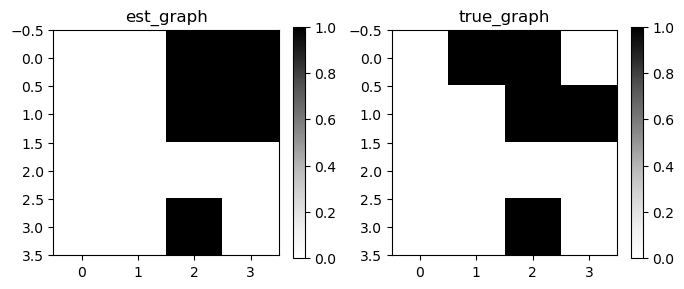

FDR: 0.2
Recall: 0.8
Precision: 0.8
F1 score: 0.8
SHD score: 2
-------------------------------------------------- 





In [33]:
# Choose the best method   
for method in methods:

    print(f'Method: {method}')

    # Fit the model
    if method == 'GOLEM':
        model = methods[method](num_iter=2.5e4)
    else:
        model = methods[method]()
        
    # Fit the model
    model.learn(df1)
        
    # Get the DAG
    pred_dag = model.causal_matrix

    # Plot results
    GraphDAG(pred_dag, true, 'result')

    mt = MetricsDAG(pred_dag, true)
    print(f'FDR: {mt.metrics["fdr"]}')
    print(f'Recall: {mt.metrics["recall"]}')
    print(f'Precision: {mt.metrics["precision"]}')
    print(f'F1 score: {mt.metrics["F1"]}')
    print(f'SHD score: {mt.metrics["shd"]}')
    print('-' * 50, '\n')     
            
print('\n')

## Encoding expert knowledge

In [32]:
# Instantiate and encode priori knowledge
priori_knowledge = PrioriKnowledge(n_nodes=4)

# Add required & forbidden edges
priori_knowledge.add_required_edges([(0, 2), (1, 2), (3, 2), (1, 3), (0, 1)])
priori_knowledge.add_forbidden_edges([(2, 0), (2, 1), (2, 3), (0, 3), (3, 0)])

In [33]:
labels = {0: 'Confounder', 1: 'Discount', 2: 'Sales', 3: 'Mediator'}

In [34]:
# Instantiate the model with expert knowledge
pc_priori = PC(priori_knowledge=priori_knowledge)

# Learn
pc_priori.learn(df1)

In [35]:
pred_priori = pc_priori.causal_matrix
pred_priori

Tensor([[0, 1, 1, 0],
        [1, 0, 1, 1],
        [0, 0, 0, 0],
        [0, 1, 1, 0]])

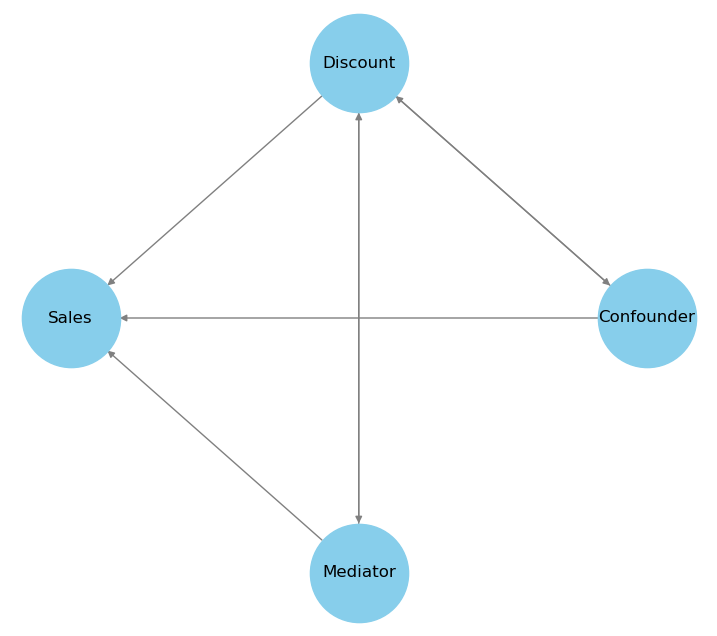

In [36]:
# Draw the discovered DAG 
priori_pred = nx.DiGraph(pred_priori)
pos = nx.circular_layout(priori_pred)
plt.figure(figsize=(9, 8))
nx.draw_networkx(G=priori_pred, with_labels=False, node_color='skyblue', node_size=5000, font_size=14, font_color='black', edge_color='gray', pos=pos)

nx.draw_networkx_labels(G, pos, labels, font_size=12)

# Remove the border
plt.gca().set_frame_on(False)

# Show the plot
plt.show();

## Falsification of DAG

In [34]:
# Import the necessary libraries and functions for this demo
import numpy as np
import pandas as pd
import networkx as nx

from dowhy.gcm.falsify import falsify_graph, FalsifyConst, plot_local_insights, run_validations, apply_suggestions
from dowhy.gcm.independence_test.generalised_cov_measure import generalised_cov_based
from dowhy.gcm.util import plot
from dowhy.gcm.util.general import set_random_seed
from dowhy.gcm.ml import SklearnRegressionModel

# Set random seed
set_random_seed(1332)

Test permutations of given graph: 100%|████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.42s/it]


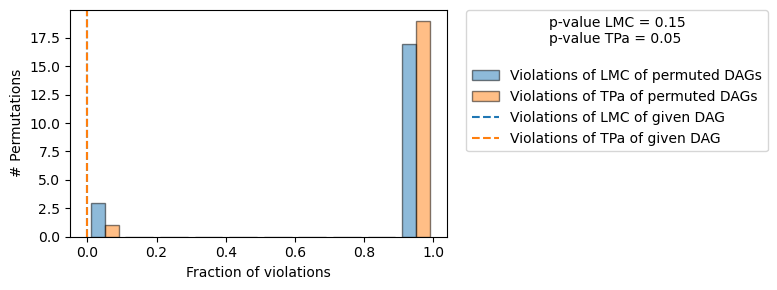

+-------------------------------------------------------------------------------------------------------+
|                                         Falsification Summary                                         |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 1 / 20 of the permutations lie in the Markov                     |
| equivalence class of the given DAG (p-value: 0.05).                                                   |
| The given DAG violates 0/1 LMCs and is better than 85.0% of the permuted DAGs (p-value: 0.15).        |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+


In [35]:
result = falsify_graph(G, df1, plot_histogram=True)
# Summarize the result
print(result)